# Jane Street Market Prediction (#5.3)
## Dimensionality Reduction Evaluation

Notebook Navigation<br>
[All](https://www.kaggle.com/wendellavila/janestreet-index/) | [#1](https://www.kaggle.com/wendellavila/janestreet-model-selection/) | [#2.1](https://www.kaggle.com/wendellavila/janestreet-preprocessing-selection) | [#2.2](https://www.kaggle.com/wendellavila/janestreet-data-preprocessing) | [#3](https://www.kaggle.com/wendellavila/janestreet-regularization-selection) | [#4](https://www.kaggle.com/wendellavila/janestreet-hyperparameter-tuning) | [#4.1](https://www.kaggle.com/wendellavila/janestreet-hyperparameter-evaluation) | [#5.1](https://www.kaggle.com/wendellavila/janestreet-pca) | [#5.2](https://www.kaggle.com/wendellavila/janestreet-autoencoder) | [#5.3](https://www.kaggle.com/wendellavila/janestreet-dimensionality-reduction-evaluation) |[#6](https://www.kaggle.com/wendellavila/janestreet-ensemble)

## Imports

In [1]:
#import janestreet
import os
import glob
import IPython

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 150)
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import load_model
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## Visualization

In [2]:
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'b')
    plt.plot(epochs, val_metrics, 'g')
    if metric == 'AUC':
        plt.axhline(y=0.5,ls=":",c="gray")
        plt.ylim(ymin=0.48)
    elif metric == 'MSE':
        plt.axhline(y=0.0,ls=":",c="gray")
        plt.ylim(ymin=-0.05, ymax=0.25)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

## Misc

In [3]:
def set_seed(seed : int):    
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [4]:
# weighted average as per Donate et al.'s formula
# https://doi.org/10.1016/j.neucom.2012.02.053
def weighted_average(a):
    w = []
    n = len(a)
    for i in range(1, n + 1):
        i = 2 if i == 1 else i
        w.append(1 / (2**(n + 1 - i)))
    return np.average(a, weights = w)

In [5]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
      def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [6]:
class Hyperparameters:
  def __init__(self, topology, dropout_rates, learning_rate, activation, num_input,
               num_batch, num_epochs, label_smoothing, use_batchnorm, use_encoder):
    self.topology = topology
    self.dropout_rates = dropout_rates
    self.learning_rate = learning_rate
    self.activation = activation
    self.num_input = num_input
    self.num_batch = num_batch
    self.num_epochs = num_epochs
    self.label_smoothing = label_smoothing
    self.use_batchnorm = use_batchnorm
    self.use_encoder = use_encoder

## Utility Score

In [7]:
def utility_score(d, w, r, a):
    Pi = np.bincount(d, w * r * a)
    t = np.sum(Pi) / np.sqrt(np.sum(Pi ** 2)) * np.sqrt(250 / len(Pi))
    u = min(max(t, 0), 6) * np.sum(Pi)
    return u

## CV - Purged Group Time Series Split

In [8]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

## Building and Training Models

### Defining model

In [9]:
def create_model(topology, dropout_rates, num_input, num_output, lrate, activation,
                 label_smoothing, use_batchnorm, use_encoder):
    
    inp = layers.Input(shape = (num_input,), name='X_train')
    
    x = inp
    if use_encoder == True:
        autoencoder, encoder = create_autoencoder(num_input,num_output,noise=0.05)
        encoder.load_weights('../input/janestreet-autoencoder/encoder.h5')
        x = encoder(x)
    if use_batchnorm == True:
        x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rates[0])(x)
        
    for i in range(len(topology)): 
        x = layers.Dense(topology[i])(x)
        if use_batchnorm == True:
            x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Dropout(dropout_rates[i+1])(x)
    
    x = layers.Dense(num_output)(x)
    out = layers.Activation('sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=out)
    
    opt = tf.keras.optimizers.Adam(learning_rate = lrate)
    model.compile(optimizer = opt,
                  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = label_smoothing),
                  metrics = tf.keras.metrics.AUC(name='AUC'))
    
    return model

### Defining Autoencoder

In [10]:
def create_autoencoder(num_input,num_output,noise=0.05):
    i = layers.Input(num_input)
    encoded = layers.BatchNormalization()(i)
    encoded = layers.GaussianNoise(noise)(encoded)
    encoded = layers.Dense(64,activation='relu')(encoded)
    decoded = layers.Dropout(0.2)(encoded)
    decoded = layers.Dense(num_input,name='decoded')(decoded)
    x = layers.Dense(32,activation='relu')(decoded)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(num_output,activation='sigmoid',name='label_output')(x)
    
    encoder = tf.keras.models.Model(inputs=i,outputs=decoded)
    autoencoder = tf.keras.models.Model(inputs=i,outputs=[decoded,x])

    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                        loss={'decoded':'mse','label_output':'binary_crossentropy'})
    return autoencoder, encoder

### Defining Training

In [11]:
def train_model(name, hp, n_folds):
    
    print(f'{name}: Training...')
    cv = PurgedGroupTimeSeriesSplit(
        n_splits=n_folds,
        max_train_group_size=150,
        group_gap=20,
        max_test_group_size=60
    )
    
    for fold, (train_index, test_index) in enumerate(cv.split(train_data, groups=train_data['date'].values)):
        
        print(f'{name} - Fold {fold+1} of {n_folds}')
        train_set = train_data.iloc[train_index]
        test_set = train_data.iloc[test_index]
        
        X_train = train_set.loc[:, features].values
        X_test = test_set.loc[:, features].values
        
        y_train = np.stack([(train_set[col] > 0).astype('int') for col in resp_cols]).T #Multitarget
        y_test = np.stack([(test_set[col] > 0).astype('int') for col in resp_cols]).T #Multitarget
        model = create_model(hp.topology, hp.dropout_rates, hp.num_input, len(resp_cols), hp.learning_rate,
                             hp.activation, hp.label_smoothing, hp.use_batchnorm, hp.use_encoder)
        metric = 'AUC'
        metric_mode = 'max'
        
        early_stopping = EarlyStopping(monitor=f'val_{metric}',patience=12,min_delta=0.0001, mode=metric_mode,
                                   restore_best_weights=True)
        #rlr = ReduceLROnPlateau(monitor=f'val_{metric}', factor=0.1, patience=5, verbose=0, min_delta = 0.0001, mode=metric_mode)
        
        callbacks = [early_stopping, [ClearTrainingOutput()]]

        history = model.fit(X_train, y_train,
                            batch_size = hp.num_batch,
                            epochs = hp.num_epochs,
                            validation_data = (X_test, y_test),
                            callbacks=callbacks,
                            verbose=2)
        
        plot_metric(history, metric)
        model.save(f'./{name}-fold{str(fold+1)}-seed{str(SEED)}.h5')

### Defining Utility Score Validation

In [12]:
def validate_model(name, n_folds, n_seeds):
    print(f'{name}: Validating...')
    
    #validation data
    X_val = val_data.loc[:, features].values
    y_val = val_data.loc[:, 'action'].values 
    
    scores = []
    
    for SEED in range(n_seeds):
        set_seed(SEED)
        #loading pretrained models
        models = []
        for i in range(n_folds):
            models.append(tf.keras.models.load_model(f'./{name}-fold{str(i+1)}-seed{str(SEED)}.h5'))
        print(f'SEED {SEED} - All models loaded.')
    
        curr_val_preds = []
        for model in models:
            curr_val_pred = model.predict(X_val)
            curr_val_pred = np.array([np.mean(preds) for preds in curr_val_pred])
            curr_val_preds.append(curr_val_pred)
        curr_val_preds_avg = np.asarray([weighted_average(idx) for idx in zip(*curr_val_preds)])
        curr_val_preds_avg = ((curr_val_preds_avg > 0.501)*1)
            
        curr_uscore = utility_score(val_data['date'].values, val_data['weight'].values,
                                        val_data['resp'].values, curr_val_preds_avg)
        print(f'SEED {SEED} {name} {n_folds}-fold Utility Score: {curr_uscore}\n')
        scores.append(curr_uscore)
        
    print(f'Average {n_folds}-fold Utility Score: {np.mean(scores)}\n')

### Training and validating

In [13]:
#defining hyperparameters
n_seeds = 5
n_folds = 5
num_batch = 4096
num_epochs = 200
num_input = 130#len(features)

In [14]:
topology = [208, 48, 112, 848, 624]
dropout_rates = [0.15543385946124283, 0.4769936942603337, 0.2004355862256995, 0.4212563172737503, 0.46071906728999595, 0.43182424636157835]
learning_rate = 0.001
activation = 'swish'

label_smoothing = 0.47213403813669336
use_batchnorm = True
use_encoder = False
model1_hyperparameters = Hyperparameters(topology, dropout_rates, learning_rate,
                                  activation, num_input, num_batch, num_epochs,
                                  label_smoothing, use_batchnorm, use_encoder)

In [15]:
train_data = pd.read_pickle('../input/janestreet-data-preprocessing/train-mean-indicator.pkl')
val_data = pd.read_pickle('../input/janestreet-data-preprocessing/val-mean-indicator.pkl')
features = [col for col in train_data.columns if 'feature' in col]
resp_cols = [col for col in train_data.columns if 'resp' in col]
model1_hyperparameters.num_input = len(features)

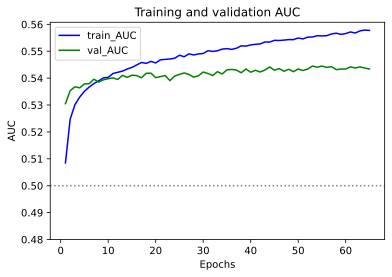

In [16]:
#training model
for SEED in range(n_seeds):
    set_seed(SEED)
    train_model('None', model1_hyperparameters, n_folds)

In [17]:
validate_model('None', n_folds, n_seeds)

None: Validating...
SEED 0 - All models loaded.
SEED 0 None 5-fold Utility Score: 904.0290768154304

SEED 1 - All models loaded.
SEED 1 None 5-fold Utility Score: 881.2051694184357

SEED 2 - All models loaded.
SEED 2 None 5-fold Utility Score: 909.7298711185997

SEED 3 - All models loaded.
SEED 3 None 5-fold Utility Score: 810.1396118476918

SEED 4 - All models loaded.
SEED 4 None 5-fold Utility Score: 818.1536109235226

Average 5-fold Utility Score: 864.6514680247361



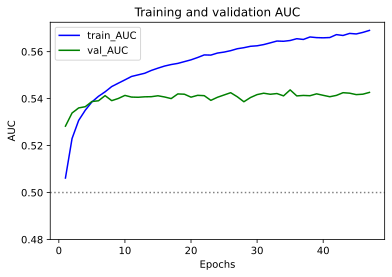

In [18]:
#training model
model1_hyperparameters.use_encoder = True
model1_hyperparameters.use_batchnorm = True
for SEED in range(n_seeds):
    set_seed(SEED)
    train_model('Autoencoder', model1_hyperparameters, n_folds)

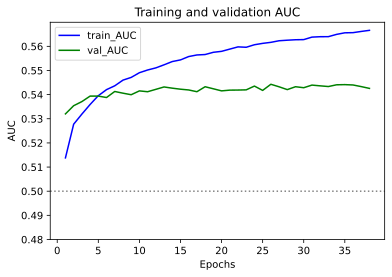

In [19]:
#training model
model1_hyperparameters.use_encoder = True
model1_hyperparameters.use_batchnorm = False
for SEED in range(n_seeds):
    set_seed(SEED)
    train_model('Autoencoder_no_batchnorm', model1_hyperparameters, n_folds)

In [20]:
validate_model('Autoencoder', n_folds, n_seeds)

Autoencoder: Validating...
SEED 0 - All models loaded.
SEED 0 Autoencoder 5-fold Utility Score: 801.688321155876

SEED 1 - All models loaded.
SEED 1 Autoencoder 5-fold Utility Score: 938.1829261264818

SEED 2 - All models loaded.
SEED 2 Autoencoder 5-fold Utility Score: 922.1782503426181

SEED 3 - All models loaded.
SEED 3 Autoencoder 5-fold Utility Score: 958.5091982737832

SEED 4 - All models loaded.
SEED 4 Autoencoder 5-fold Utility Score: 761.8918051946173

Average 5-fold Utility Score: 876.4901002186753



In [21]:
validate_model('Autoencoder_no_batchnorm', n_folds, n_seeds)

Autoencoder_no_batchnorm: Validating...
SEED 0 - All models loaded.
SEED 0 Autoencoder_no_batchnorm 5-fold Utility Score: 881.9961479629467

SEED 1 - All models loaded.
SEED 1 Autoencoder_no_batchnorm 5-fold Utility Score: 728.9051001990846

SEED 2 - All models loaded.
SEED 2 Autoencoder_no_batchnorm 5-fold Utility Score: 937.2173152925988

SEED 3 - All models loaded.
SEED 3 Autoencoder_no_batchnorm 5-fold Utility Score: 616.0589280022359

SEED 4 - All models loaded.
SEED 4 Autoencoder_no_batchnorm 5-fold Utility Score: 759.7573555001203

Average 5-fold Utility Score: 784.7869693913973



In [22]:
train_data = pd.read_pickle('../input/janestreet-pca/train-pca.pkl')
val_data = pd.read_pickle('../input/janestreet-pca/val-pca.pkl')
features = [col for col in train_data.columns if 'feature' in col]
resp_cols = [col for col in train_data.columns if 'resp' in col]
model1_hyperparameters.num_input = len(features)

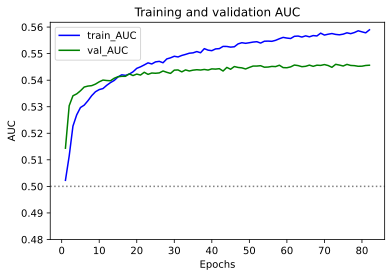

In [23]:
#training model
model1_hyperparameters.use_encoder = False
model1_hyperparameters.use_batchnorm = True
for SEED in range(n_seeds):
    set_seed(SEED)
    train_model('PCA', model1_hyperparameters, n_folds)

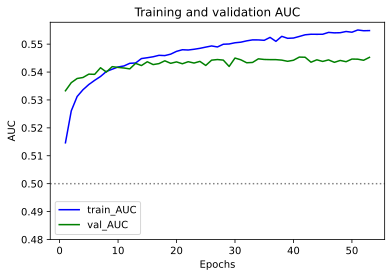

In [24]:
#training model
model1_hyperparameters.use_encoder = False
model1_hyperparameters.use_batchnorm = False
for SEED in range(n_seeds):
    set_seed(SEED)
    train_model('PCA_no_batchnorm', model1_hyperparameters, n_folds)

In [25]:
validate_model('PCA', n_folds, n_seeds)

PCA: Validating...
SEED 0 - All models loaded.
SEED 0 PCA 5-fold Utility Score: 844.4323962452003

SEED 1 - All models loaded.
SEED 1 PCA 5-fold Utility Score: 753.1823420606447

SEED 2 - All models loaded.
SEED 2 PCA 5-fold Utility Score: 769.4060889197967

SEED 3 - All models loaded.
SEED 3 PCA 5-fold Utility Score: 804.0592001437822

SEED 4 - All models loaded.
SEED 4 PCA 5-fold Utility Score: 790.0540729874717

Average 5-fold Utility Score: 792.2268200713792



In [26]:
validate_model('PCA_no_batchnorm', n_folds, n_seeds)

PCA_no_batchnorm: Validating...
SEED 0 - All models loaded.
SEED 0 PCA_no_batchnorm 5-fold Utility Score: 854.0695083017567

SEED 1 - All models loaded.
SEED 1 PCA_no_batchnorm 5-fold Utility Score: 715.8710553255415

SEED 2 - All models loaded.
SEED 2 PCA_no_batchnorm 5-fold Utility Score: 780.8677145736277

SEED 3 - All models loaded.
SEED 3 PCA_no_batchnorm 5-fold Utility Score: 735.2373497353791

SEED 4 - All models loaded.
SEED 4 PCA_no_batchnorm 5-fold Utility Score: 785.0523699208568

Average 5-fold Utility Score: 774.2195995714325

